In [1]:
import os
import glob
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from attentionVis import AttentionVis
from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage.filters import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


# for i in {1..10}; do python3 -m gather_atts.py; done



/opt/conda/envs/neuroformer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/neuroformer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/tmp/ipykernel_25916/2328680474.py:41: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter, uniform_filter
/tmp/ipykernel_25916/2328680474.py:41: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter, uni

In [2]:
""" 

-- DATA --
neuroformer/data/OneCombo3_V1AL/
df = response
video_stack = stimulus
DOWNLOAD DATA URL = https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=sharing


"""

RESPONSE_PATH = "data/Combo3_V1AL/Combo3_V1AL_response.csv"
STIMULUS_PATH = "data/Combo3_V1AL/Combo3_V1AL_stimulus.pt"

if not os.path.exists(RESPONSE_PATH):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/1jNvA4f-epdpRmeG9s2E-2Sfo-pwYbjeY?usp=share_link"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="./data")



df = pd.read_csv(RESPONSE_PATH).iloc[:, 1:]
video_stack = torch.load(STIMULUS_PATH)

DATASET = "Combo3_V1AL"


In [3]:
video_stack.shape

torch.Size([3, 640, 1, 64, 112])

In [4]:
df

,Time,ID,Trial
0,0.104882,484,1
1,0.113316,309,1
2,0.118826,440,1
3,0.136037,241,1
4,0.137907,328,1
...,...,...,...
57199,31.837727,472,60
57200,31.852254,146,60
57201,31.865928,471,60
57202,31.898499,324,60


torch.Size([3, 640, 1, 64, 112])


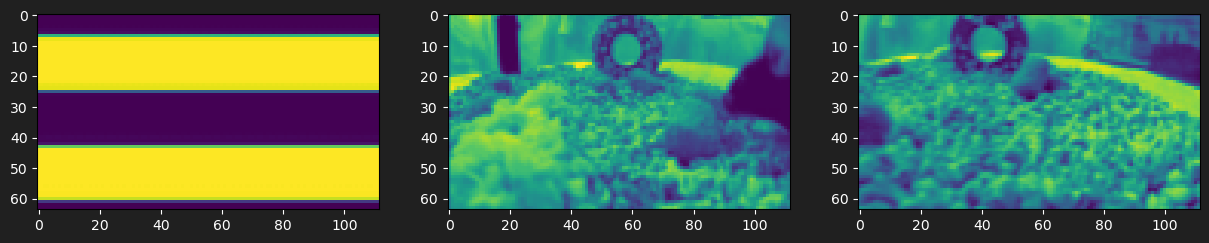

In [5]:
print(video_stack.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(video_stack[i, 1, 0].permute(0, 1))



In [6]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
frame_window = 0.1
window = 0.5
window_prev = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)



In [7]:
df

,Time,ID,Trial,Interval,real_interval,Interval_2
0,0.104882,484,1,0.5,0.15,0.5
1,0.113316,309,1,0.5,0.15,0.5
2,0.118826,440,1,0.5,0.15,0.5
3,0.136037,241,1,0.5,0.15,0.5
4,0.137907,328,1,0.5,0.15,0.5
...,...,...,...,...,...,...
57199,31.837727,472,60,32.0,31.85,32.0
57200,31.852254,146,60,32.0,31.90,32.0
57201,31.865928,471,60,32.0,31.90,32.0
57202,31.898499,324,60,32.0,31.90,32.0


In [8]:
# from SpikeVidUtils import get_interval_trials

# intervals = get_interval_trials(df, window, window_prev, dt)
intervals = None



In [9]:
top_p = 0.75
top_p_ids = df.groupby('ID').count().sort_values(by='Trial', ascending=False)[:int(top_p * len(df['ID'].unique()))].index.tolist()
df = df[df['ID'].isin(top_p_ids)].reset_index(drop=True)
df.groupby('ID').count().sort_values(by='Trial', ascending=False)[:int(top_p * len(df['ID'].unique()))]

,Time,Trial,Interval,real_interval,Interval_2
ID,,,,,
348,634,634,634,634,634
168,595,595,595,595,595
417,568,568,568,568,568
353,563,563,563,563,563
513,492,492,492,492,492
...,...,...,...,...,...
213,116,116,116,116,116
222,116,116,116,116,116
367,116,116,116,116,116


In [10]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(4)



In [11]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])model_path
var_group = 'Interval_2'
n_unique = len(df.groupby([var_group, 'Trial']).size())
df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
# df.groupby(['Interval_2', 'Trial']).size().mean()

Interval_2  Trial
7.0         22       71
5.5         35       69
6.0         23       69
1.0         21       64
5.5         37       61
                     ..
13.5        19       19
            28       19
            46       19
14.0        16       19
            37       19
Length: 764, dtype: int64

In [ ]:
video_

In [12]:
from SpikeVidUtils import SpikeTimeVidData2

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
kernel_size = (2, 8, 8)
n_embd = 256
n_embd_frames = 64
frame_feats = video_stack

frame_block_size = ((20 // kernel_size[0] * 64 * 112) // (n_embd_frames))
# frame_block_size = 5 * 14 * 14
frame_feats = video_stack.transpose(1, 2)

# frame_block_size = 560
prev_id_block_size = 74
id_block_size = 30   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
# neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
neurons = sorted(list(set(df['ID'].unique())))
# pixels = sorted(np.unique(frames).tolist())
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))



0.5

In [13]:
# df.groupby(['Trial', 'Interval_2']).size().nlargest(20)

In [14]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
n_trial = [2, 8, 14, 19]
for n_stim in range(df['Trial'].max() // 20):
    # n_trial = [2, 4, 6, 8, 10, 12, 14, 18]
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t)
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)



In [15]:
len(train_data['Trial'].unique()) / (len(train_data['Trial'].unique()) + len(test_data['Trial'].unique()))

0.8

In [16]:
frame_feats.shape



torch.Size([3, 1, 640, 64, 112])

<AxesSubplot: >

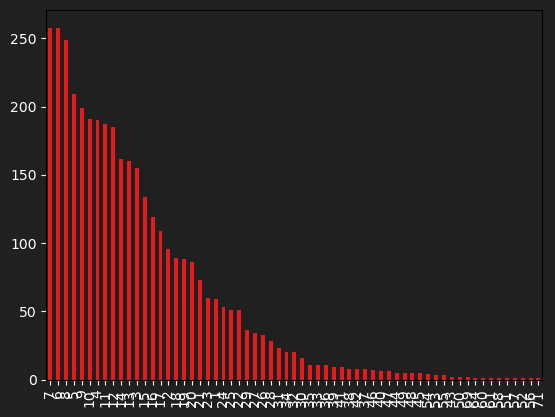

In [17]:
df.groupby(['Interval', 'Trial']).size().value_counts().plot.bar()

In [28]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, 
                                  prev_id_block_size, window, dt, frame_memory, 
                                  stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  intervals=intervals, start_interval=1, dataset=DATASET)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, 
                                  prev_id_block_size, window, dt, frame_memory, 
                                  stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  intervals=intervals, start_interval=1, dataset=DATASET)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, 
                                  prev_id_block_size, window, dt, frame_memory, 
                                  stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  intervals=intervals, start_interval=1, dataset=DATASET)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')



Length: 38825 Neurons: 292 Pixels: 0.
id block size: 30
frames: 1120, id: 30
Length: 10796 Neurons: 292 Pixels: 0.
id block size: 30
frames: 1120, id: 30
Length: 633 Neurons: 292 Pixels: 0.
id block size: 30
frames: 1120, id: 30
train: 3006, test: 754


In [29]:
"""

Load Model

"""

from model_neuroformer import GPT

precision = []
recall = []
f1 = []

n_seed = 25
models = []
# for n in [0, 25, 50]:
# set_seed(25)

from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
# for is_conv in [True, False]:    
conv_layer = True
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25, sparse_topk_frame=None, sparse_topk_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=4, n_state_history_layers=4, n_stimulus_layers=8, self_att_layers=4,
                        n_layer=10, n_head=2, n_embd=n_embd, n_embd_frames=n_embd_frames, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        conv_layer=conv_layer, kernel_size=kernel_size,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt)  # 0.35
model = GPT(mconf)
# model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/tensorboard/V1_AL_cont/cont0+conv_emask_Cont:True_0.50.05_sparseTrue_conv_True_shuffle:True_batch:224_sparse_(None_None)_pos_emb:False_temp_emb:True_drop:0.2_dt:True_2.0_0.5_max0.05_(4, 4, 6)_2_256_nembframe64.pt", map_location='cpu'))

from trainer import Trainer, TrainerConfig
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-01-21-14:18-e:19-b:239-l:4-h:2-ne:512-higher_order.pt"))


layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 300
batch_size = 32 * 6
shuffle = True

# title =  f'window:{window}_cc'
title = "window:0.05_prev:0.5_fw:0.1_cc2"
model_path = f"""./models/tensorboard/V1_AL/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(n_dt)}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""
# model.load_state_dict(torch.load(model_path, map_location='cpu'))
# model.load_state_dict(torch.load("/Users/antonis/Downloads/[16, 17, 18, 19]_Cont_True_0.50.05_sparseFalse_conv_True_shuffle_True_batch_224_sparse_(None_None)_pos_emb_False_temp_emb_True_drop_0.2_dt_True_2.0_0.5_max0.05_(4, 0, 6)_2_256_nembframe64-2.pt", map_location='cpu'))

tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=True, patience=3, warmup_tokens=8e9, 
                    decay_weights=True, weight_decay=0.1, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, dist=False)
# f"/home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")


# trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
# trainer.train()  

286720
256 11


In [30]:
loader = DataLoader(train_dataset, shuffle=False, pin_memory=False)
iterable = iter(loader)

In [31]:
x, y = next(iterable)

for key in x.keys():
    print(key, x[key].shape)

this is V1AL, n_stim: 0
id_prev torch.Size([1, 74])
dt_prev torch.Size([1, 73])
pad_prev torch.Size([1])
id torch.Size([1, 30])
dt torch.Size([1, 29])
pad torch.Size([1])
interval torch.Size([1])
trial torch.Size([1])
frames torch.Size([1, 1, 2, 64, 112])
stimulus torch.Size([1])
cid torch.Size([1, 2])
pid torch.Size([1, 2])
f_idx torch.Size([1, 2])


In [32]:
x, y = next(iterable)

model.cpu()
features, logits, loss = model(x, y)
# x['id'], x['interval'], x['trial']


# T = len(x['id'])
# P = x['pad']
# T_prev = len(x['id_prev'])
# P_prev = x['pad_prev']

# iv = float(x['interval'])

# xid = x['id'][: T - P]
# xid = [itos[int(i)] for i in xid]

# xid_prev = x['id_prev'][: T_prev - P_prev]
# xid_prev = [itos[int(i)] for i in xid_prev]

# print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
# print(f"x: {xid}")

# print(f"xid_prev: {xid_prev}")

# tdiff = 0.2
# t_var = 'Time' # 'Interval'
# int_var = 'pid'
# # df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# # df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]


this is V1AL, n_stim: 0


RuntimeError: The size of tensor a (74) must match the size of tensor b (73) at non-singleton dimension 1

: 

In [ ]:
stoi_dt

In [ ]:
x['dt']

In [ ]:
x.keys()

In [ ]:
x['id']

In [ ]:
x['interval']

In [ ]:
"""

RUN SIMULATION

"""

from utils import *
from IPython.utils import io
# top_p=0.25, top_p_t=0.9, temp=2.

model.load_state_dict(torch.load(model_path, map_location='cpu'))

trials = train_data['Trial'].unique()[::4]

results_dict = dict()
# for n in range(2, 20):
df_pred = None
df_true = None
n_p = 0.3   # (n + 1) * 0.05
temp = 2
# stoi['SOS'] = 2000
for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() as captured:
        print(f"Trial: {trial}")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = SpikeTimeVidData2(df_trial, None, block_size, id_block_size, frame_block_size, 
                                        prev_id_block_size, window, dt, frame_memory, 
                                        stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, 
                                        pred=False, window_prev=window_prev, frame_window=frame_window,
                                        intervals=None, start_interval=1)
        trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
        results_trial = predict_raster_recursive_time_auto(model, trial_loader, window, window_prev, stoi, itos_dt, itos=itos, sample=True, top_p=0.75, top_p_t=0.75, temp=1.3, temp_t=1.3, frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])

# df_preds[n] = df_pred
# print(f"--- n: {n}, n_p: {n_p}, temp: {temp} ---")
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )
# results_dict[n] = (scores)

In [ ]:
"""

Split data into full-stimulus trials

"""


t_1, t_2 = 35, 36
trial_data_1 = df[df['Trial'] == t_1]
trial_dataset_1 = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
trial_loader_1 = DataLoader(trial_dataset_1, shuffle=False, pin_memory=False)

def loader_trial(df, n_trial):
    trial_data = df[df['Trial'] == n_trial]
    trial_dataset = SpikeTimeVidData2(trial_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False, window_prev=window_prev)
    trial_loader = DataLoader(trial_dataset, shuffle=False, pin_memory=False)
    return trial_loader

trial_data_1 = loader_trial(df, t_1)
trial_data_2 = loader_trial(df, t_2)

iterable1 = iter(trial_data_1)
iterable2 = iter(trial_data_2)


n_trial = [2, 8, 14, 19]

n_1 = []
for n_stim in range(3): # range(df['Trial'].max() // 20):
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t - 2)
        n_1.append(trial)
test2_data = df[df['Trial'].isin(n_1)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)


n_2 = []
for n_stim in range(3): # range(df['Trial'].max() // 20):
    for n_t in n_trial:
        trial = (n_stim + 1) * 20 - (n_t - 1)
        n_2.append(trial)
test3_data = df[df['Trial'].isin(n_2)].reset_index(drop=True)
# small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

print(f"trials: {test2_data['Trial'].unique()}")
print(f"trials: {test3_data['Trial'].unique()}")

from analysis import *
from utils import *
from SpikeVidUtils import create_full_trial

df_pred_full = create_full_trial(df_pred)
df_1 = create_full_trial(df, trials)
df_2 = create_full_trial(df, n_1)
df_3 = create_full_trial(df, n_2)

window_pred = 1

df_list = [df_pred_full, df_1, df_2, df_3]

for df_ in df_list:
    df_['Interval'] = make_intervals(df_, window_pred)
    df_ = df_[df_['Interval'] > window_prev]
    df_ = df_[df_['Interval'] < window]


window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))


# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)

In [ ]:
"""

Evaluate results

"""


from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")

set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6)
plt.legend(fontsize=20)

dir_name = os.path.dirname(model_path)
plt.savefig(os.path.join(dir_name, 'psth_corr.svg'))

plot_distribution(df_1, df_pred, save_path=os.path.join(dir_name, 'plot_dist.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

In [ ]:
iterable = iter(train_dataset)

In [ ]:
# iterable = iter(train_dataset)
x, y = next(iterable)
x['id'], x['interval'], x['trial']

T = len(x['id'])
P = x['pad']
T_prev = len(x['id_prev'])
P_prev = x['pad_prev']

iv = float(x['interval'])

xid = x['id'][: T - P]
xid = [itos[int(i)] for i in xid]

xid_prev = x['id_prev'][: T_prev - P_prev]
xid_prev = [itos[int(i)] for i in xid_prev]

print(f"iv: {iv}, ix+window: {iv + window} pid: {x['pid']} cid: {x['cid']}")
print(f"x: {xid}")

print(f"xid_prev: {xid_prev}")

tdiff = 0.2
t_var = 'Time' # 'Interval'
int_var = 'pid'
# df[(df[t_var] >= iv - tdiff) & (df[t_var] <= iv + (window + tdiff)) & (df['Trial'] == int(x['trial']))]
# df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x[int_var][1] + tdiff)) & (df['Trial'] == int(x['trial']))]
df[(df[t_var] >= float(x[int_var][0]) - tdiff) & (df[t_var] <= float(x['cid'][1] + tdiff)) & (df['Trial'] == int(x['trial']))]

In [ ]:
from SpikeVidUtils import get_frame_idx

loader = DataLoader(train_dataset, shuffle=False, pin_memory=False)
iterable = iter(loader)

In [ ]:
x, y = next(iterable)

In [ ]:
x['frames'].shape